In [144]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import (
    Linear,
    Softmax,
)
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


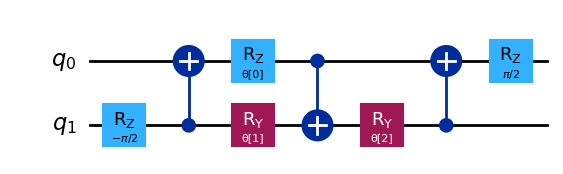

In [145]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

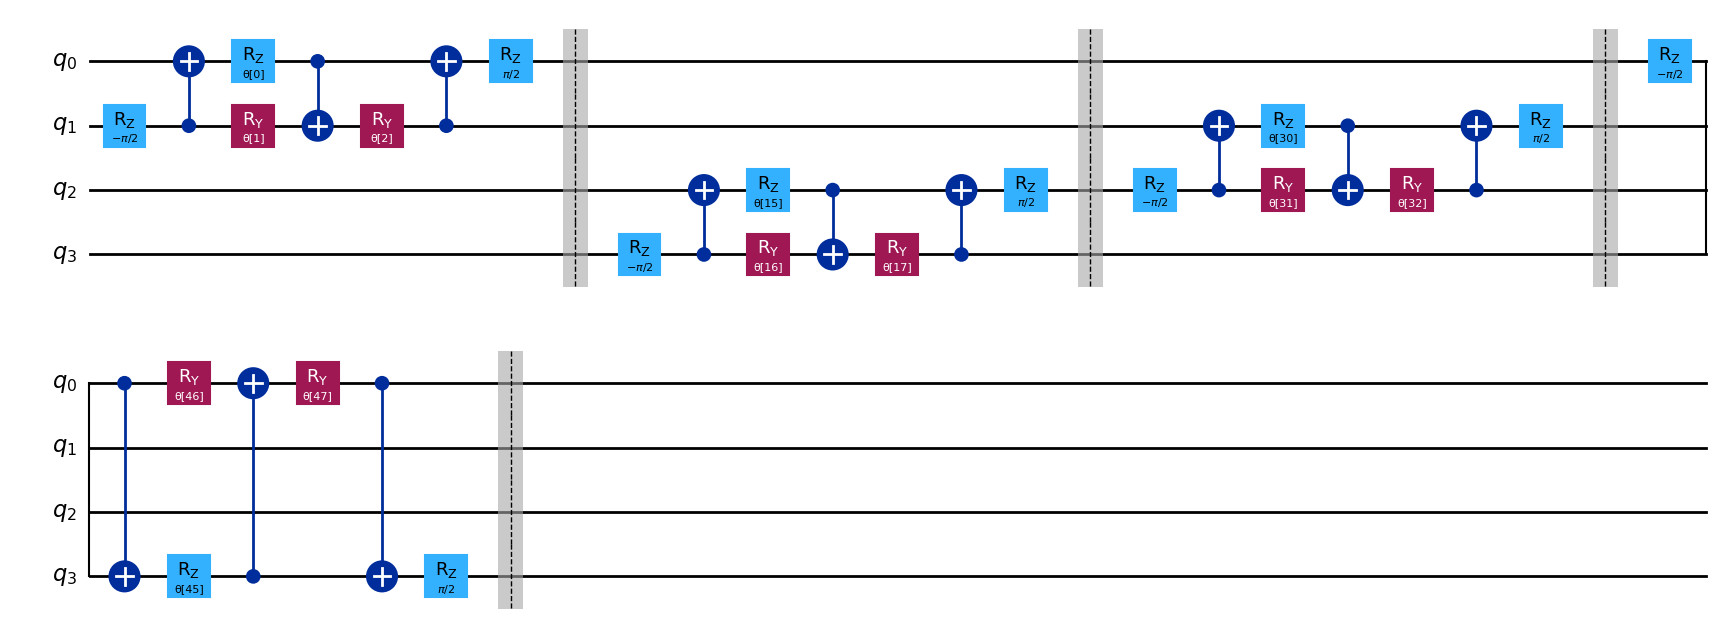

In [146]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

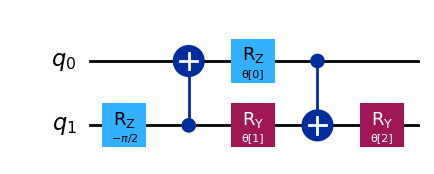

In [147]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

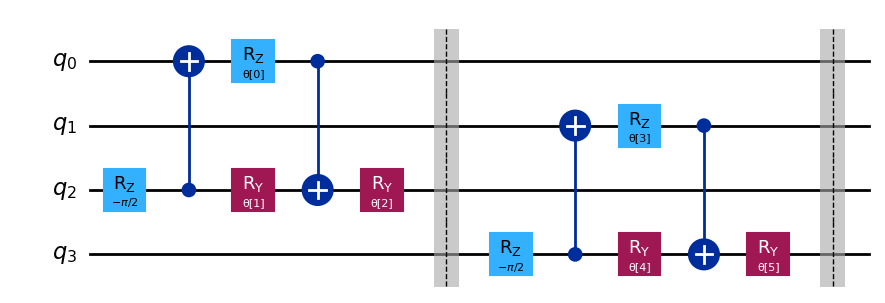

In [148]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [149]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [150]:
a = 3
b = 4

def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [151]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


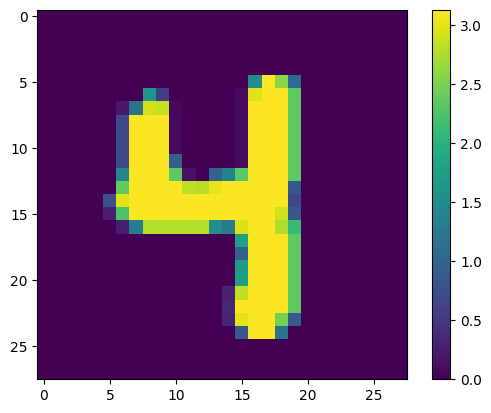

In [152]:
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

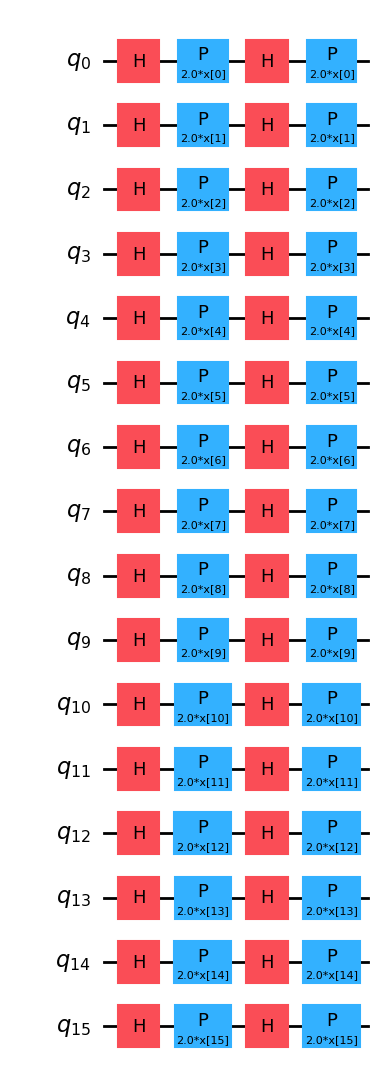

In [153]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

In [154]:
# Ansatz Instantiation
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    q_reg = QuantumRegister(16, "q_reg")
    ansatz = QuantumCircuit(q_reg, name="Ansatz")

    # First Convolutional Layer
    ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

    # First Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

    # Second Convolutional Layer
    ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

    # Second Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

    # Third Convolutional Layer
    ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

    # # Third Pooling Layer
    # ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

    # # Fourth Convolutional Layer
    # ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

    # # Fourth Pooling Layer
    # ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    display(circuit.draw("mpl"))
    return circuit

In [155]:
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

4


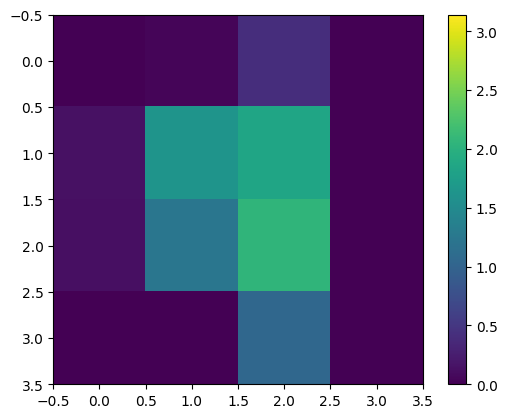

In [156]:
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [157]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)

    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)

    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [158]:
import collections
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 11973
Number of unique  3 's:  6131
Number of unique  4 's:  5842
Number of unique contradicting labels:  0

Initial number of images:  11973
Remaining non-contradicting unique images:  11973
Number of unique images: 1992
Number of unique  3 's:  1010
Number of unique  4 's:  982
Number of unique contradicting labels:  0

Initial number of images:  1992
Remaining non-contradicting unique images:  1992


In [159]:
x_reshaped = []
x1_reshaped = []

for g in resized_train_images:
    x_reshaped.append(g.reshape(1,16))

for g in resized_test_images:
    x1_reshaped.append(g.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    final_x.append(entry[0])

for entry in x1_reshaped:
    final_x1.append(entry[0])

# Easier to work with names
x = final_x
y = train_labels
x1 = final_x1
y1 = test_labels

# Setting labels to 0 or 1 to properly process.
y_temp = []
y1_temp = []

for entry in y:
    if entry == a:
        y_temp.append(0)
    elif entry == b:
        y_temp.append(1)
    elif entry == c:
        y_temp.append(2)
    elif entry == d:
        y_temp.append(3)
y=y_temp

for entry in y1:
    if entry == a:
        y1_temp.append(0)
    elif entry == b:
        y1_temp.append(1)
    elif entry == c:
        y1_temp.append(2)
    elif entry ==d:
        y1_temp.append(3)
y1=y_temp

x = np.asarray(final_x)
y = np.asarray(y)
x1 = np.asarray(final_x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:100]
y = y[0:100]
x1 = x1[0:100]
y1 = y1[0:100]

print(x)
print(y)

[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.         0.45835322 0.4178733  ... 1.0285919  0.5543987  0.        ]
 [0.         0.         0.         ... 0.42139328 0.         0.        ]
 [0.         0.3017136  0.21145092 ... 0.60971284 0.7779182  0.        ]]
[1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0]


In [160]:
# Helper Functions to fix up data
def count(y):
    counta = 0
    countb = 0
    # countc = 0
    # countd = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
        # elif y[i] == 2:
        #     countc+=1
        # elif y[i] == 3:
        #     countd+=1
    return(counta, countb)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0
    # count2 = 0
    # count3 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        # elif y[i] == 2:
        #     if count2 < max_count:
        #         x_balanced.append(x[i])
        #         y_balanced.append(y[i])
        #         count2 += 1
        # elif y[i] == 3:
        #     if count3 < max_count:
        #         x_balanced.append(x[i])
        #         y_balanced.append(y[i])
        #         count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [161]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (48, 52)
max_count = 48
balanced: (48, 48)
shuffled: (48, 48)
final: [[0.         0.         0.         ... 0.00176    0.5848215  0.03922276]
 [0.         0.5629472  1.1563172  ... 1.2083629  0.34772485 0.        ]
 [0.05858272 0.3849362  0.00125714 ... 0.1923424  0.81588376 0.2677708 ]
 ...
 [0.         0.         0.29894787 ... 0.2883879  0.09101693 0.        ]
 [0.         0.         0.20868523 ... 0.2866279  0.09956548 0.        ]
 [0.         0.         0.         ... 0.11515401 0.33766776 0.02489137]]
[0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1
 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0]


In [162]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32)
Y = torch.tensor(y, dtype=torch.long)
X1 = torch.tensor(x1, dtype=torch.float32)
Y1 = torch.tensor(y1, dtype=torch.long)

In [163]:
num_classes = 4
Y = torch.nn.functional.one_hot(Y, num_classes=num_classes).float()
Y1 = torch.nn.functional.one_hot(Y1, num_classes=num_classes).float()

In [164]:
# Check GPU Availability
from qiskit_aer import AerSimulator
print(AerSimulator().available_devices())
print(AerSimulator().available_methods())

('CPU', 'GPU')
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop', 'tensor_network')


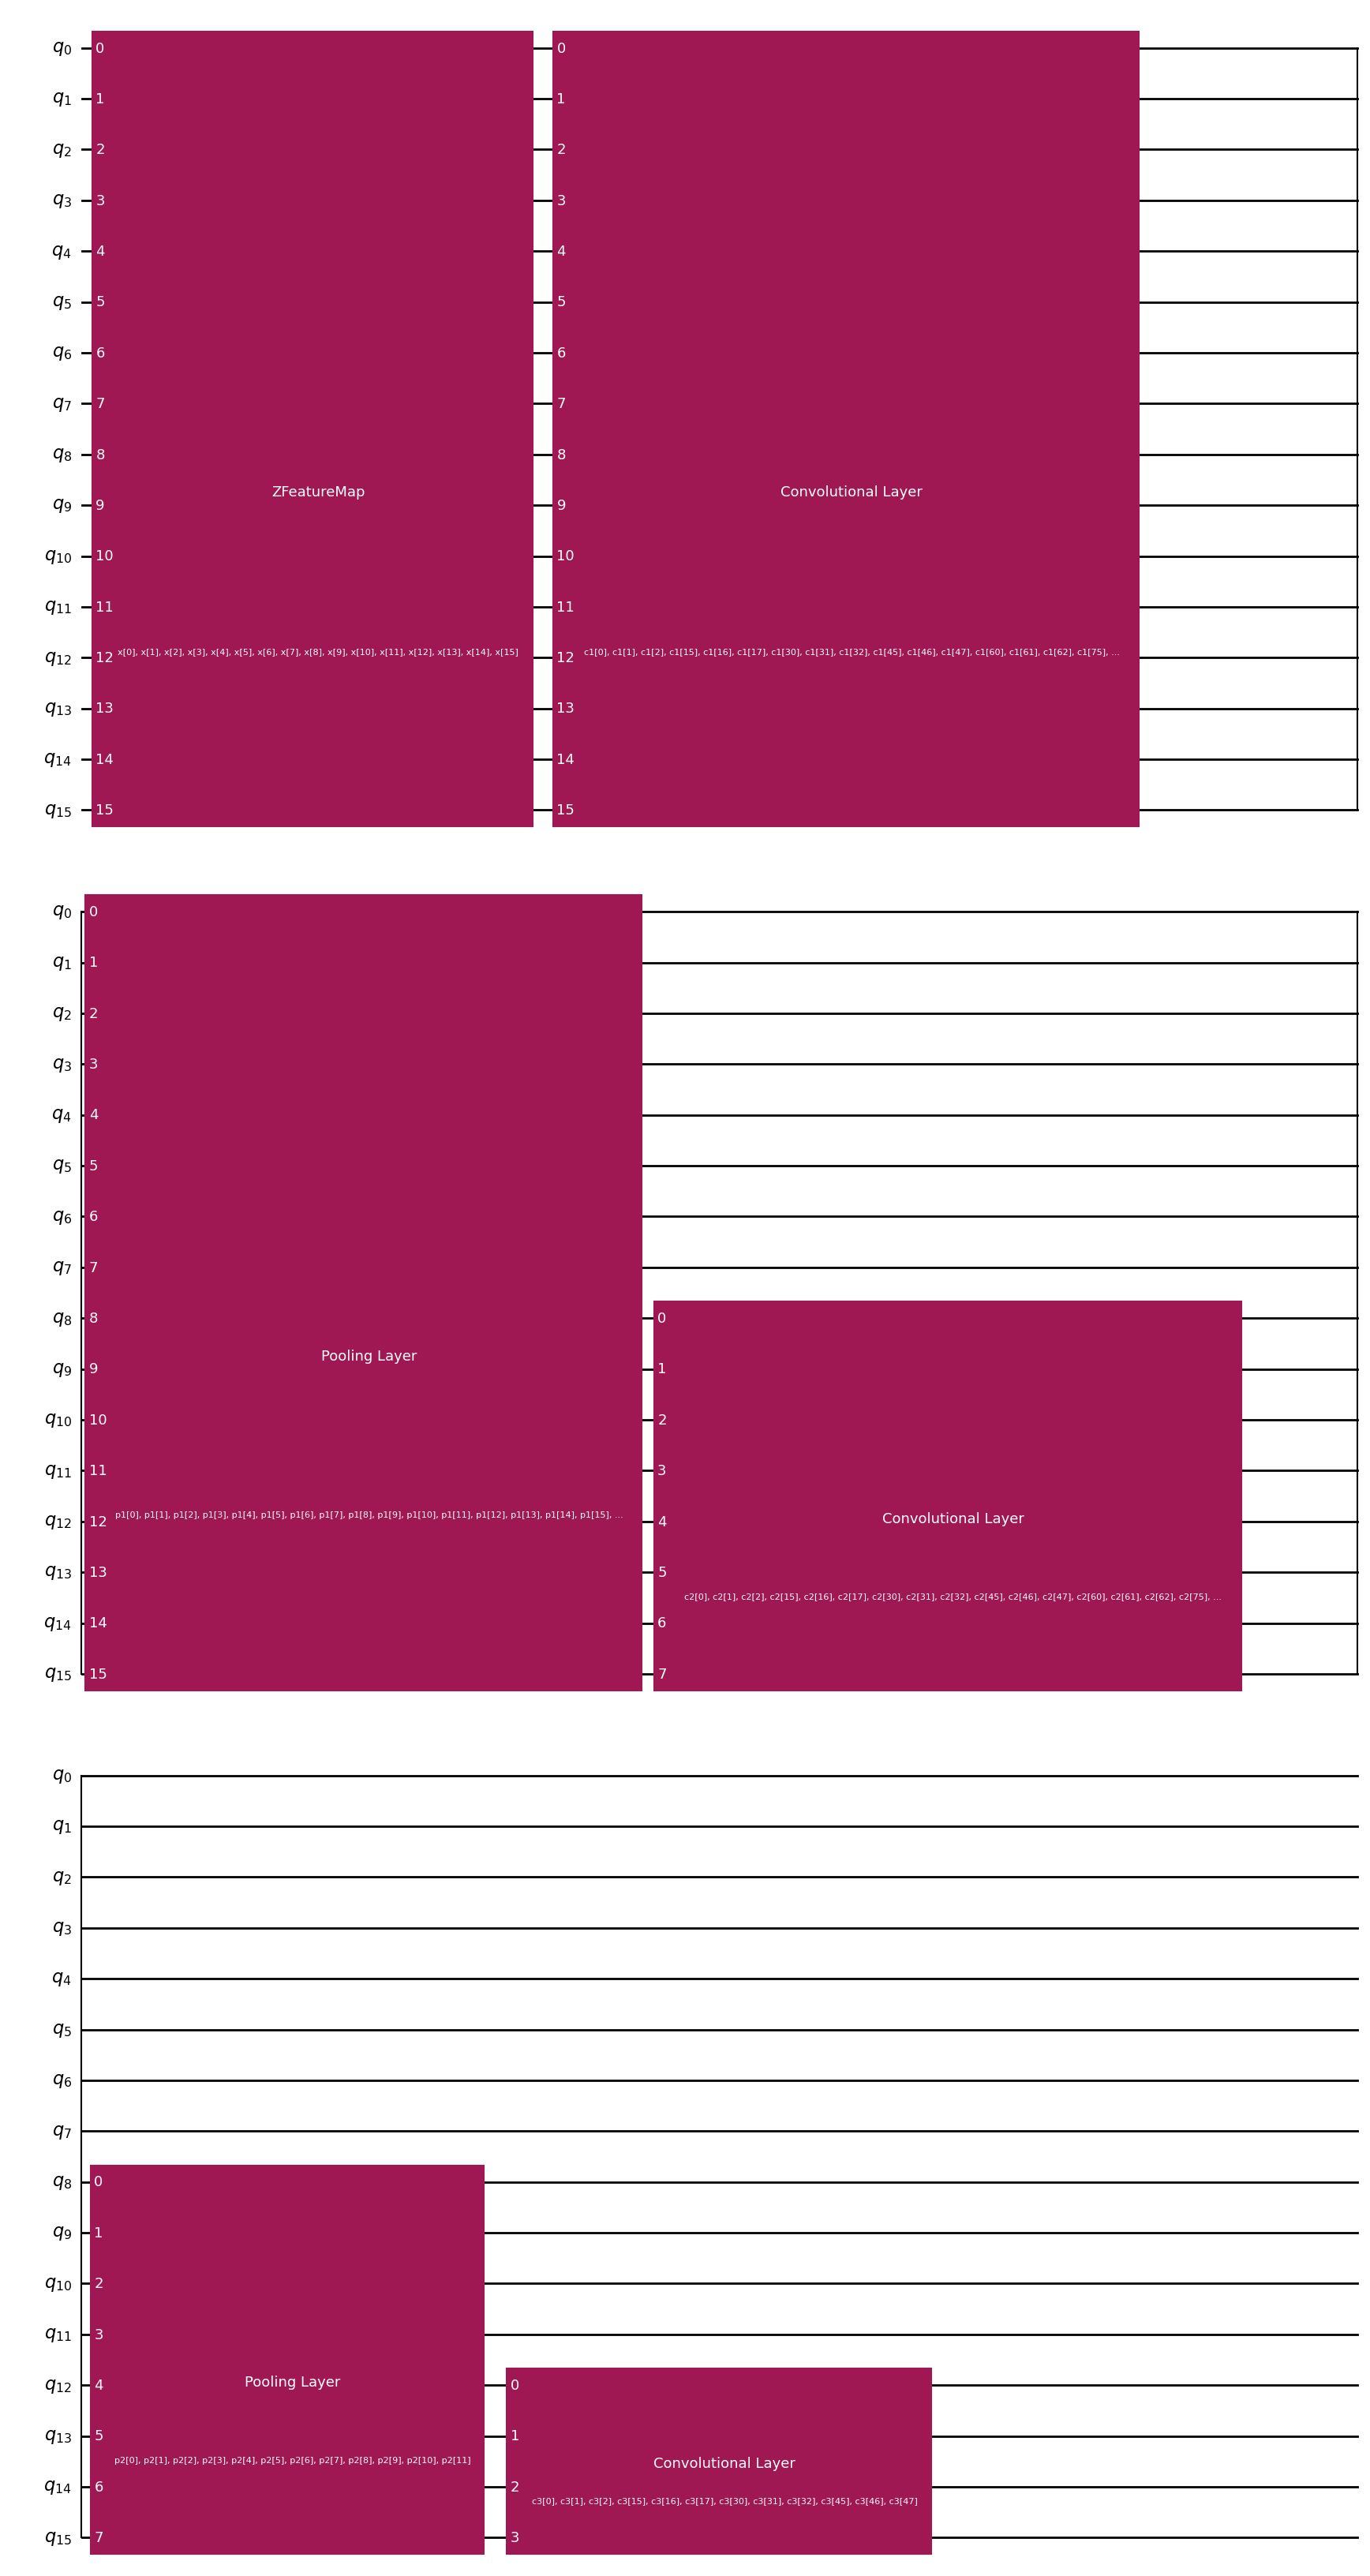

/tmp/ipykernel_909/2834986390.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_909/2834986390.py:18: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.01953125,  0.03515625],
       [-0.05664062,  0.08203125],
       [ 0.0234375 ,  0.08789062],
       [ 0.03710938,  0.01757812],
       [ 0.        ,  0.        ],
       [ 0.02539062,  0.04882812],
       [ 0.03125   ,  0.01171875],
       [-0.0078125 ,  0.01171875],
       [ 0.015625  ,  0.02929688],
       [ 0.04882812, -0.03320312],
       [ 0.02539062,  0.02929688],
       [ 0.14257812, -0.05664062],
       [ 0.03125   ,  0.00976562],
       [ 0.00390625,  0.01367188],
       [ 0.04296875, -0.01757812],
       [ 0.0234375 ,  0.02539062],
       [-0.00976562, -0.046875  ],
       [-0.00195312,  0.05078125],
       [ 0.046875  , -0.00976562],
       [-0.01171875, -0.01757812]])

In [165]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils import algorithm_globals
algorithm_globals.random_seed = 65
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = 42)

num_qubits = 16

observable_z16 = SparsePauliOp.from_sparse_list([("Z", [15], 1)], num_qubits=num_qubits)
observable_z15 = SparsePauliOp.from_sparse_list([("Z", [14], 1)], num_qubits=num_qubits)
# observable_z14 = SparsePauliOp.from_sparse_list([("Z", [13], 1)], num_qubits=num_qubits)
# observable_z13 = SparsePauliOp.from_sparse_list([("Z", [12], 1)], num_qubits=num_qubits)
observables = [observable_z15, observable_z16]

estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    observables = observables,
    input_gradients = True,
)

# Checking Data Forward Result
weights = algorithm_globals.random.random(estimator.num_weights)
estimator.forward(input_data = x1[:20], weights = weights)

In [166]:
from qiskit_machine_learning.connectors import TorchConnector
from torch.nn import CrossEntropyLoss, Module
qnn = TorchConnector(estimator, weights)

In [167]:
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module
        self.softmax = nn.Softmax(dim=-1)

    # def set_weights(self, weights):
    #     self._parameters = weights

    # def get_weights(self):
    #     return self.params

    def forward(self, x):
        x = self.qnn_module(x)
        x = self.softmax(x)
        return x

model = Model(qnn).to("cuda")
 # Put model into training mode

In [168]:
loss_func = CrossEntropyLoss()
def objective_function(weights):
    print(weights)
    total_loss = 0.0  # Initialize total loss
    # for i in range(len(X)):  # Iterate through all samples
    model = Model(TorchConnector(estimator, weights)).to("cuda")
    model.train()
    output = model(X)
    loss = loss_func(output, Y)
    total_loss += loss.item()
    loss_list.append(total_loss)
    clear_output(wait=True)
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    plt.show()
    
    return total_loss

In [169]:
result = minimize(
    fun=objective_function,
    x0=weights,  # Initial weights
    method='COBYLA',
    options={'maxiter': 200}  # Adjust as needed
)


[0.04739149 0.51822218 0.37485856 0.22867852 0.94172319 0.59450155
 0.27885084 0.04311748 0.14423914 0.01065197 0.31514662 0.02572118
 0.94437018 0.49617256 0.37480029 0.85658163 0.62928319 0.48360592
 0.90823988 0.36357074 0.55447095 0.99886465 0.16437728 0.53619405
 0.44985538 0.43854221 0.76961269 0.02814414 0.18110959 0.86157729
 0.15099079 0.95998429 0.17225772 0.76006771 0.98976908 0.61388771
 0.10841687 0.02479108 0.84646607 0.52363837 0.4453262  0.8571329
 0.29850865 0.68735996 0.06313347 0.27832244 0.119579   0.56486756
 0.69628681 0.16386791 0.2011384  0.89324696 0.12953977 0.5510009
 0.00239028 0.00220001 0.89117068 0.00964528 0.44767653 0.92968593
 0.73875611 0.27210871 0.79533861 0.90281889 0.23706067 0.7387345
 0.21415986 0.50341226 0.73610556 0.81939391 0.967283   0.5365026
 0.35429018 0.82951867 0.77437619 0.85992346 0.41188035 0.33967985
 0.49212632 0.33851408 0.31962511 0.29908783 0.53755339 0.60217737
 0.57685468 0.42617699 0.3800623  0.42100774 0.64434626 0.5458217


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
model = Model(TorchConnector(estimator, result.x)).to("cuda")
torch.save(model.state_dict(), "Estimator2Class")

Model(
  (qnn_module): TorchConnector()
  (softmax): Softmax(dim=-1)
)

In [137]:

model.eval()

Model(
  (qnn_module): TorchConnector()
  (softmax): Softmax(dim=-1)
)

In [140]:
acc = 0
for i in range(Y.size(dim=0)):
    val = model(X[i])
    print(torch.argmax(val))
    if (torch.argmax(val) == torch.argmax(Y[i])):
        # print(torch.argmax(val))
        acc+=1
print("accuracy: ", acc/(Y.size(dim=0)))

tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
accuracy:  0.59375


In [298]:
model.parameters()

<generator object Module.parameters at 0x7f5cf60cbae0>

In [341]:
result

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 105.78866171836853
       x: [ 4.739e-02  1.518e+00 ...  8.244e-01  1.681e-01]
    nfev: 100
   maxcv: 0.0

In [ ]:
from qiskit_algorithms.optimizers import COBYLA
loss_func = COBYLA

for epoch in range(1):  # Or your desired number of epochs
    total_loss = []

    # No need for manual batching if you're not using a DataLoader
    for i in range(len(X)):  # Iterate through all samples
        optimizer.zero_grad(set_to_none=True)
        output = model(X[i])  # X[i] is now a tensor
        print(output)
        loss = loss_func(output, Y[i])  # y[i] is now a tensor
        print(loss)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())

    avg_loss = np.mean(total_loss) # changed to numpy
    print(f"Epoch {epoch+1}/100, Loss: {avg_loss}")

tensor([ 0.3687,  0.4329, -0.3987,  0.1414], grad_fn=<ViewBackward0>)
tensor(1.2021, grad_fn=<DivBackward1>)


In [59]:
torch.save(model.state_dict(), "model.pt")

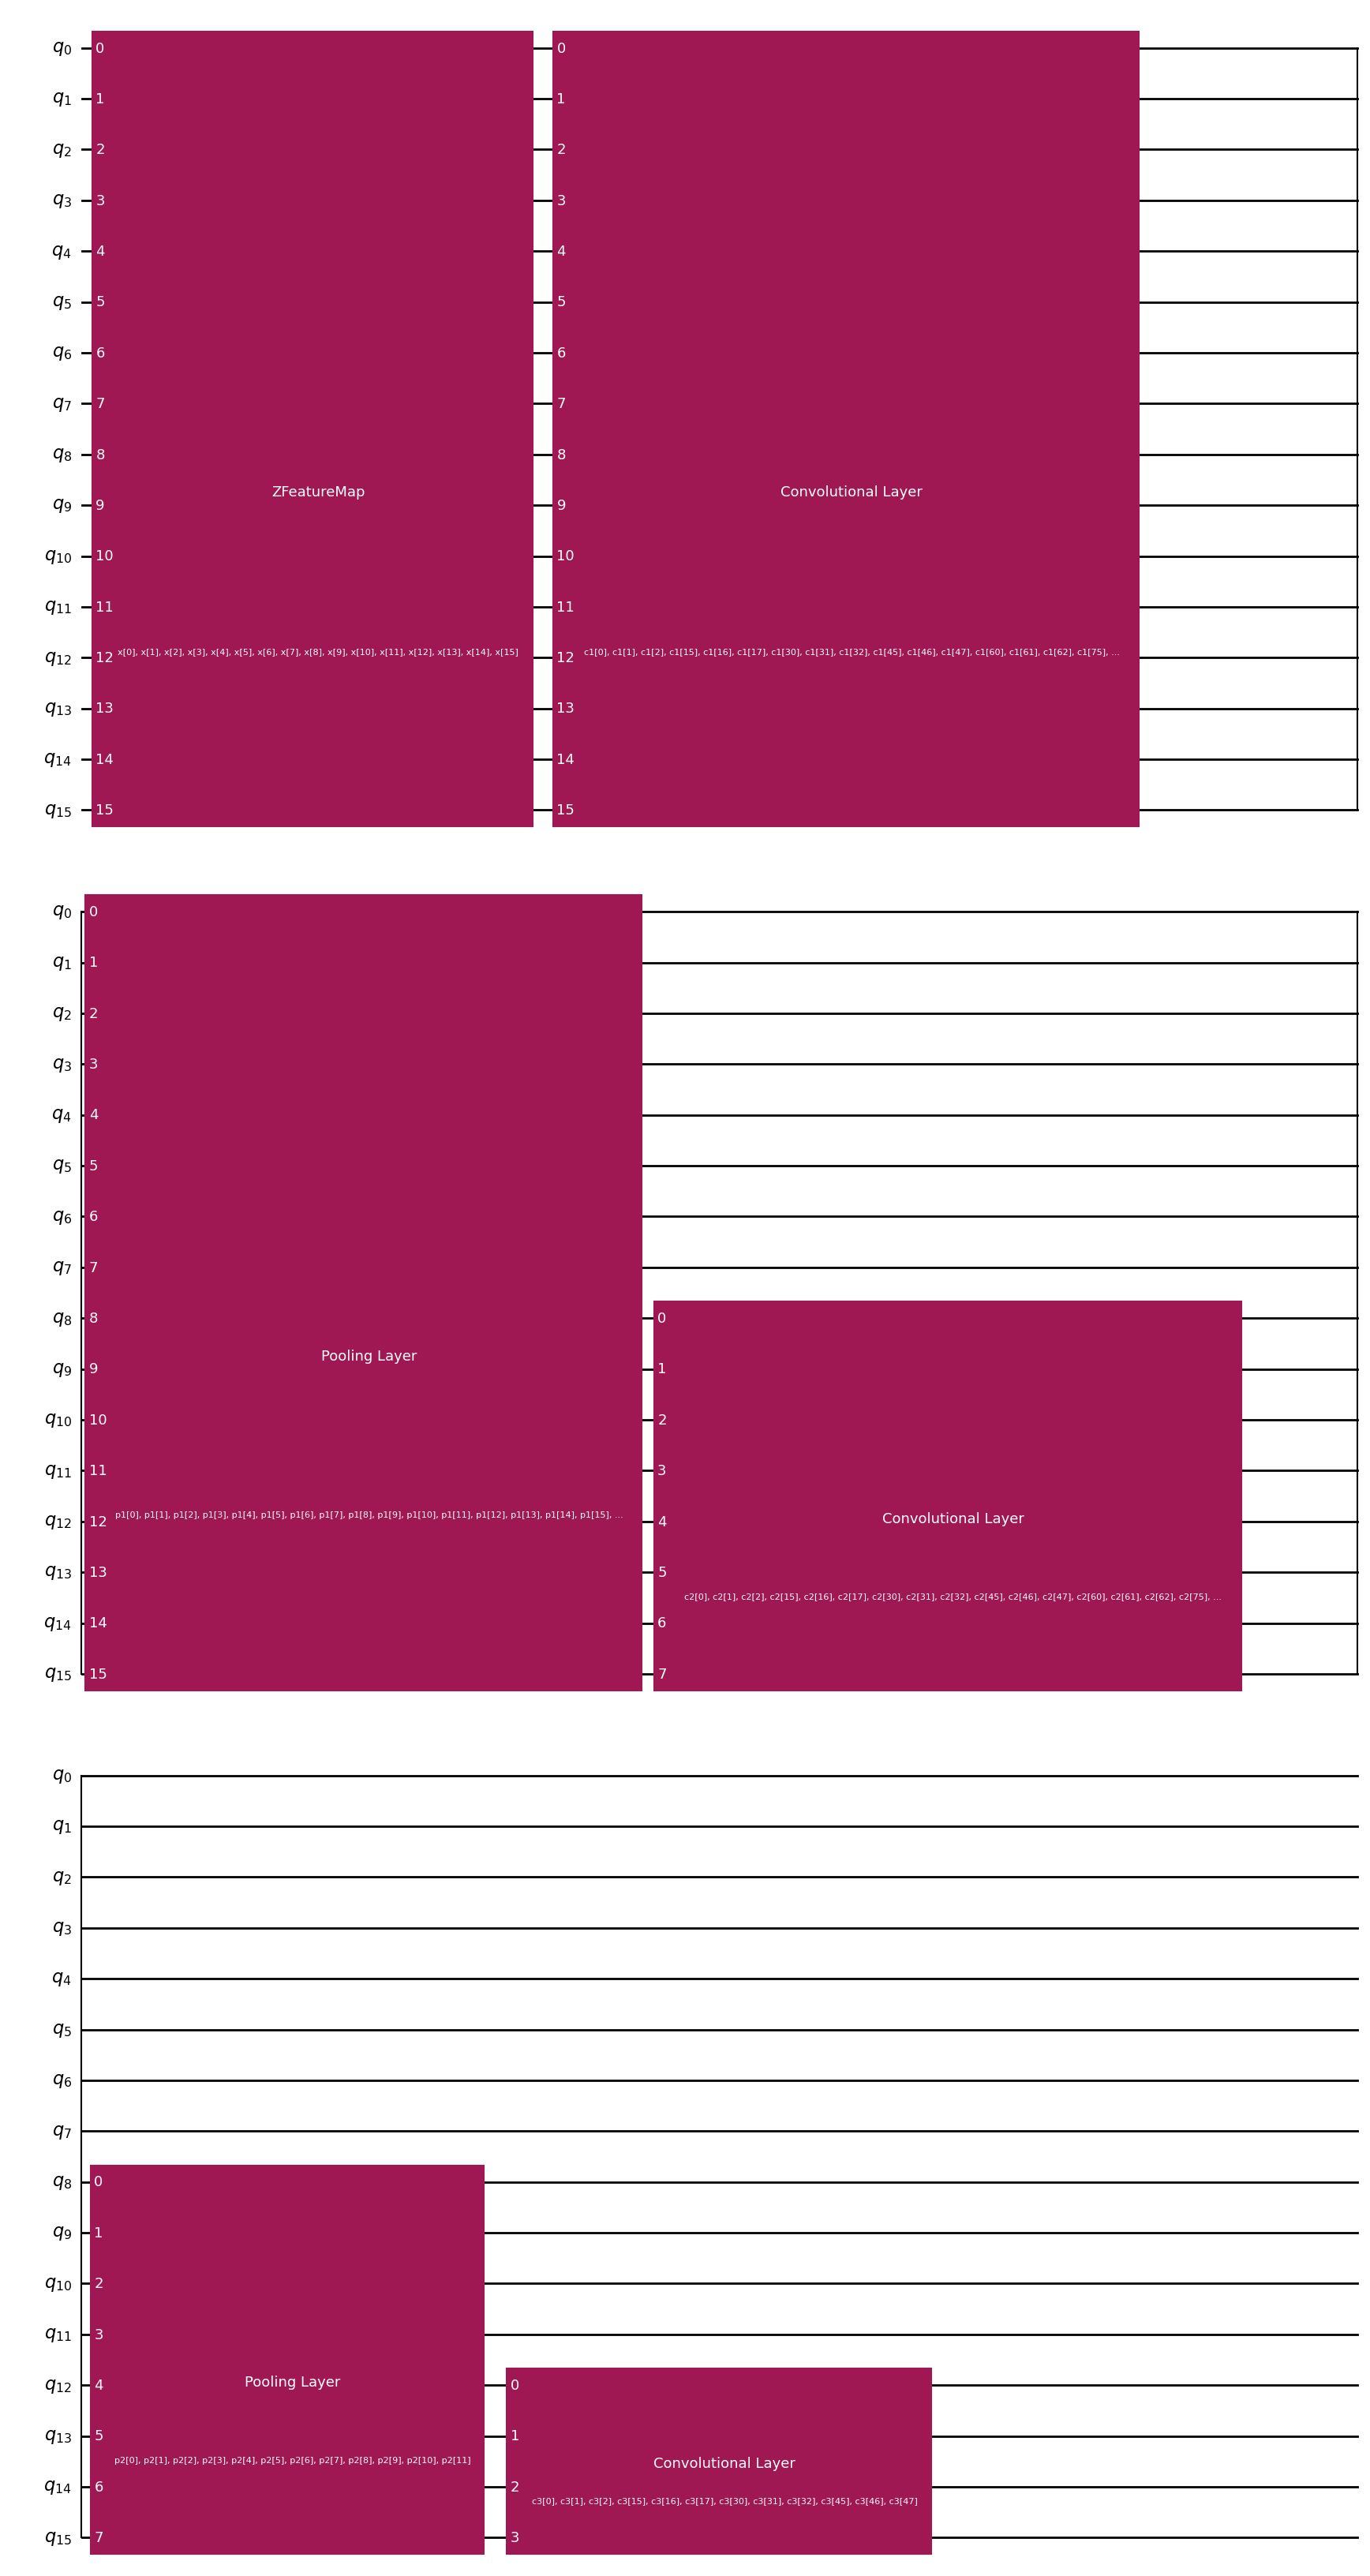

/tmp/ipykernel_48132/1595493684.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Test.load_state_dict(torch.load("model.pt"))


RuntimeError: Error(s) in loading state_dict for Model:
	Unexpected key(s) in state_dict: "qnn_module.weight", "qnn_module._weights". 

In [62]:
qnn = create_QCNN()
Test = Model(qnn)
Test.load_state_dict(torch.load("model.pt"))

NameError: name 'y_predict' is not defined

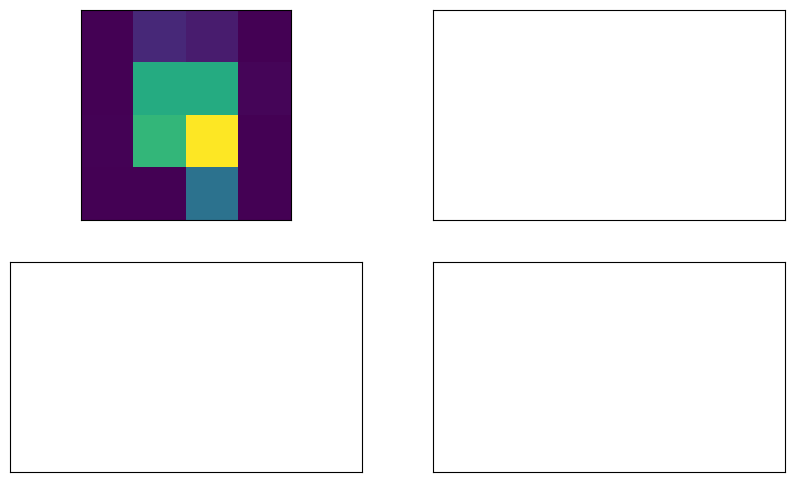

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
# Printing Actual Data
y1[:1000]

[(-1, 1),
 (-1, 1),
 (1, -1),
 (-1, 1),
 (-1, -1),
 (-1, 1),
 (1, 1),
 (-1, 1),
 (1, -1),
 (-1, -1),
 (1, 1),
 (1, -1),
 (1, 1),
 (1, -1),
 (-1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (-1, 1),
 (-1, 1),
 (1, -1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (-1, 1),
 (1, 1),
 (-1, -1),
 (1, 1),
 (-1, -1),
 (-1, 1),
 (-1, 1),
 (1, -1),
 (-1, -1),
 (1, -1),
 (-1, 1),
 (1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (1, 1),
 (1, -1),
 (-1, -1),
 (-1, 1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (1, -1),
 (1, 1),
 (-1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (1, 1),
 (1, 1),
 (-1, -1),
 (1, 1),
 (-1, -1),
 (1, 1),
 (-1, 1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (-1, 1),
 (-1, 1),
 (-1, -1),
 (-1, -1),
 (-1, 1),
 (-1, -1),
 (-1, 1),
 (1, -1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, -1),
 (1, -1),
 (1, -1),
 (-1, 1),
 (-1, -1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, -1),
 (-1, -1),
 (1, 1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (1, -1),
 (1

In [ ]:
# Printing Predicted Data for Comparision
y_predict[:1000]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
# Printing Weights for Backup Checkpoint
weights = classifier.weights
weights

QiskitMachineLearningError: 'The model has not been fitted yet'

In [ ]:
# Saving Model
classifier.save("Classifier2ClassCircuit1_2QB(4)")

In [ ]:
# y_temp = []
# y1_temp = []

# for entry in y:
#     if entry == 0:
#         y_temp.append([-1,-1])
#     elif entry == 1:
#         y_temp.append([-1,1])
#     elif entry == 2:
#         y_temp.append([1,-1])
#     elif entry == 3:
#         y_temp.append([1,1])
# y=np.asarray(y_temp)

# for entry in y1:
#     if entry == 0:
#         y1_temp.append([-1,-1])
#     elif entry == 1:
#         y1_temp.append([-1,1])
#     elif entry == 2:
#         y1_temp.append([1,-1])
#     elif entry == 3:
#         y1_temp.append([1,1])
# y1=np.asarray(y_temp)